<H2>Rental Price Index.</H2>

Trying to create a simple price index model to estimate rental trends.

Clementi District data is used for calculations. We will try to find a function that best describes the rental trends of 2bhk in this area.

In [2]:
import os
import site
site.addsitedir("/var/www/data-prototyping/")
from pygurucore.tables import GuruTable
import pandas as pd
from sklearn import svm
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
import numpy as np
import sqlalchemy as sa
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
t = GuruTable(table_name='fact_rentals_ura')

prop_list = sa.select([
    t.c.property_type,
    t.c.bedrooms,
    t.c.area_sqft_min,
    t.c.area_sqft_max,
    t.c.contract_year,
    t.c.contract_month,
    t.c.contract_date,
    t.c.monthly_rent]).where(t.c.bedrooms=='2' and t.c.district_code=='D05').execute().to_dataframe()

prop_list.head(10)

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent
0,Non-landed Properties,2,800,900,2012,1,2012-01-01,4800
1,Non-landed Properties,2,800,900,2012,1,2012-01-01,4900
2,Non-landed Properties,2,1200,1300,2012,1,2012-01-01,6300
3,Non-landed Properties,2,900,1000,2012,1,2012-01-01,4200
4,Non-landed Properties,2,1000,1100,2012,1,2012-01-01,6000
5,Non-landed Properties,2,1000,1100,2012,1,2012-01-01,3900
6,Non-landed Properties,2,800,900,2012,1,2012-01-01,4800
7,Non-landed Properties,2,1100,1200,2012,1,2012-01-01,4600
8,Non-landed Properties,2,1000,1100,2012,1,2012-01-01,6500
9,Non-landed Properties,2,1200,1300,2012,1,2012-01-01,7000


In [4]:
prop_list.describe()

,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,monthly_rent
count,43119,43119.000000,43107.000000,43119.000000,43119.000000,43119.000000
mean,2,919.325587,1018.746375,2013.341218,6.174308,3825.140959
std,0,186.978459,183.752991,0.964280,3.469827,1163.702740
min,2,200.000000,300.000000,2012.000000,1.000000,750.000000
25%,2,800.000000,900.000000,2013.000000,3.000000,3000.000000
50%,2,900.000000,1000.000000,2013.000000,6.000000,3500.000000
75%,2,1000.000000,1100.000000,2014.000000,9.000000,4500.000000
max,2,3000.000000,2900.000000,2015.000000,12.000000,18500.000000


In [5]:
len(prop_list)

43119

In [6]:
pd.Series(prop_list["property_type"]).unique()

array(['Non-landed Properties', 'Executive Condominium'], dtype=object)

In [7]:
columns = prop_list.columns
print("Count Null Values in columns.")
for c in columns:
    print(c + " : " + str(prop_list[c].isnull().sum()))

Count Null Values in columns.
property_type : 0
bedrooms : 0
area_sqft_min : 0
area_sqft_max : 12
contract_year : 0
contract_month : 0
contract_date : 0
monthly_rent : 0


In [8]:
prop_list[prop_list.area_sqft_min==3000]

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent
3723,Non-landed Properties,2,3000,NaN,2012,6,2012-06-01,6000
6423,Non-landed Properties,2,3000,NaN,2012,9,2012-09-01,14000
9523,Non-landed Properties,2,3000,NaN,2012,12,2012-12-01,8000
10194,Non-landed Properties,2,3000,NaN,2013,1,2013-01-01,13000
23884,Non-landed Properties,2,3000,NaN,2014,1,2014-01-01,7500
25381,Non-landed Properties,2,3000,NaN,2014,2,2014-02-01,6000
25410,Non-landed Properties,2,3000,NaN,2014,2,2014-02-01,6000
26497,Non-landed Properties,2,3000,NaN,2014,3,2014-03-01,10500
26501,Non-landed Properties,2,3000,NaN,2014,3,2014-03-01,15000
26515,Non-landed Properties,2,3000,NaN,2014,3,2014-03-01,6000


In [9]:
import datetime
from calendar import monthrange
from dateutil.relativedelta import *
start_date = datetime.date(2012,1,1)
end_date = datetime.date(2013,1,1)
td = (end_date)-(start_date)
#td = monthrange(end_date,start_date)
td

datetime.timedelta(366)

In [10]:
prop_list["running_months"] = (prop_list["contract_date"] - start_date)/30
prop_list.tail()

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent,running_months
43114,Non-landed Properties,2,800,900,2015,4,2015-04-01,2500,39 days 12:48:00
43115,Non-landed Properties,2,900,1000,2015,4,2015-04-01,2600,39 days 12:48:00
43116,Executive Condominium,2,800,900,2015,4,2015-04-01,2400,39 days 12:48:00
43117,Executive Condominium,2,800,900,2015,4,2015-04-01,2700,39 days 12:48:00
43118,Executive Condominium,2,1000,1100,2015,4,2015-04-01,2100,39 days 12:48:00


In [11]:
# Fill in null values
prop_list.fillna(3000)
prop_list = prop_list.replace(np.nan,3000, regex=True)
print(prop_list["area_sqft_max"].isnull().sum())

#Encode property_type
prop_list = prop_list.replace("Non-landed Properties",1, regex=True)
prop_list = prop_list.replace("Executive Condominium",2, regex=True)
prop_list = prop_list.replace("days*","month", regex=True)
prop_list.to_csv("//var//www//data-prototyping//Rental_pi.csv")

0


In [12]:
#Ensure days removed from csv file
prop_list = pd.read_csv("//var//www//data-prototyping//Rental_pi.csv")
prop_list.reindex_axis(sorted(prop_list.columns), axis=1)
prop_list.head()

,Unnamed: 0,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent,running_months
0,0,1,2,800,900,2012,1,2012-01-01,4800,0 days 00:00:00.000000000
1,1,1,2,800,900,2012,1,2012-01-01,4900,0 days 00:00:00.000000000
2,2,1,2,1200,1300,2012,1,2012-01-01,6300,0 days 00:00:00.000000000
3,3,1,2,900,1000,2012,1,2012-01-01,4200,0 days 00:00:00.000000000
4,4,1,2,1000,1100,2012,1,2012-01-01,6000,0 days 00:00:00.000000000


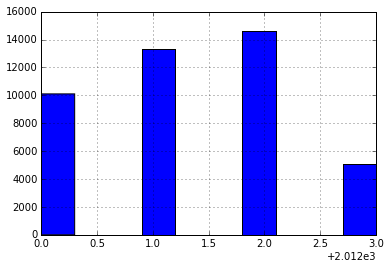

In [13]:
prop_list["contract_year"].hist()

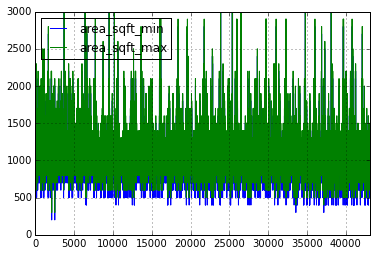

In [14]:
prop_list[["area_sqft_min","area_sqft_max"]].plot()

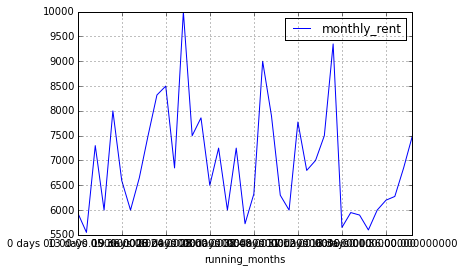

In [15]:
plt_data = prop_list[(prop_list.area_sqft_max>2000) ][["running_months","monthly_rent"]]
plt_data_grp = plt_data.groupby("running_months")
plt_data_grp.median().plot()

ValueError: could not convert string to float: '39 days 12:48:00.000000000'

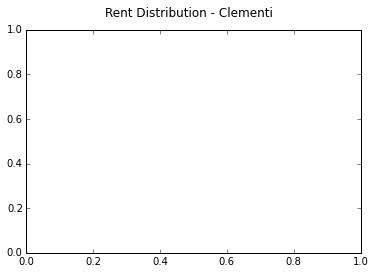

In [16]:
plt_data = prop_list[(prop_list.area_sqft_max>2000) ][["running_months","monthly_rent"]]
fig = plt.figure()
fig.suptitle("Rent Distribution - Clementi", fontsize=12)
plt.plot(plt_data["running_months"],plt_data["monthly_rent"],"ro")

In [19]:
X_cols = list(set(prop_list.columns) - set(["monthly_rent","contract_date"]))
X = prop_list[X_cols]
y = prop_list["monthly_rent"]
X=X.sort_index(axis=1)

In [20]:
clf = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(clf, X, y, cv=5, n_jobs=1);

ValueError: could not convert string to float: '39 days 12:48:00.000000000'

In [21]:
X_train = X.loc[1:35000]
y_train = y.loc[1:35000]

X_test = X.loc[35000:]
y_test = y.loc[35000:]

#len(X_test)-len(y_test)

In [22]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

#Print sum of square error

print("Training Error:" + str(np.sqrt(np.mean((regr.predict(X_train)-y_train)**2))))
print("Testing Error:" + str(np.sqrt(np.mean((regr.predict(X_test)-y_test)**2))))
print('Variance score: %.2f' % regr.score(X_test, y_test))

ValueError: could not convert string to float: '33 days 11:12:00.000000000'

ValueError: First argument must be a sequence

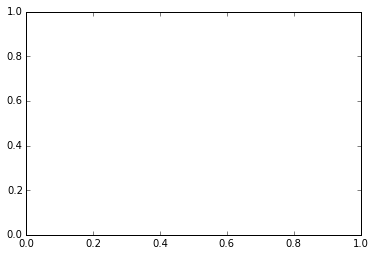

In [23]:
plt.scatter(X_test["running_months"],y_test,color='black')
plt.plot(X_test["running_months"],regr.predict(X_test),color='blue')
plt.show()

ValueError: could not convert string to float: '39 days 12:48:00.000000000'

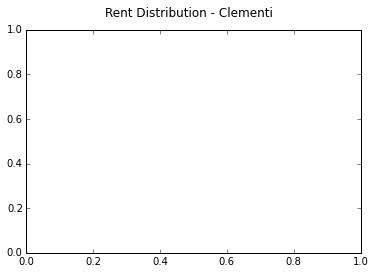

In [24]:
plt_data = prop_list[(prop_list.area_sqft_max>2000)][["running_months","monthly_rent"]]
fig = plt.figure()
fig.suptitle("Rent Distribution - Clementi", fontsize=12)
plt.plot(plt_data["running_months"],plt_data["monthly_rent"],"ro")
X = prop_list[(prop_list.area_sqft_max>2000)][X_cols]
X=X.sort_index(axis=1)
plt.subplot(211)
plt.plot(X["running_months"],regr.predict(X),color='blue')

In [25]:
# Create Ransacregressor regression object
regr = linear_model.Lasso(alpha=0.1)

# Train the model using the training sets
regr.fit(X_train, y_train)

#Print sum of square error

print("Training Error:" + str(np.sqrt(np.mean((regr.predict(X_train)-y_train)**2))))
print("Testing Error:" + str(np.sqrt(np.mean((regr.predict(X_test)-y_test)**2))))
print('Variance score: %.2f' % regr.score(X_test, y_test))

ValueError: could not convert string to float: '33 days 11:12:00.000000000'

In [ ]:
prop_list["area_sqft_max"].hist()

NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

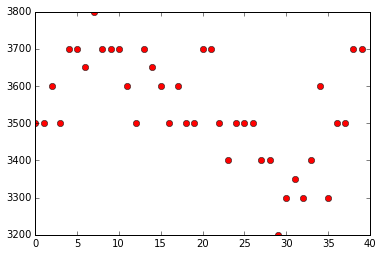

In [26]:
#Plotting Median Price 
plt_data = prop_list.groupby("running_months")
plt.plot(plt_data.median()["monthly_rent"],"ro")

# Plotting predictions
X_grouped = pd.DataFrame(plt_data.median())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped[X_cols]
X_grouped = X_grouped.sort_index(axis=1)
plt.plot(X_grouped["running_months"],regr.predict(X_grouped),color='blue')
X_grouped.head()
#print(X_grouped)

In [ ]:
#points = np.array(list(X_grouped["running_months"],plt_data.median()["monthly_rent"]))
# get x and y vectors
x = np.array(X_grouped["running_months"])
y = np.array(plt_data.median()["monthly_rent"])

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

fig = plt.figure()
fig.suptitle("Median Rent Distribution - Clementi", fontsize=12)
plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [ ]:
# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [ ]:
plt.plot(plt_data.median()["monthly_rent"])

NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

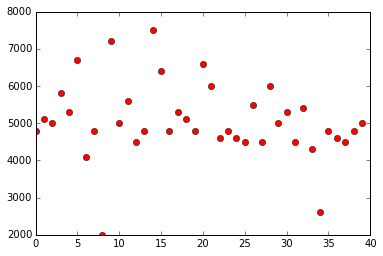

In [27]:
#Plotting Median Price 
plt_data = prop_list[(prop_list.area_sqft_max<2500)].groupby("running_months")
plt.plot(plt_data.first()["monthly_rent"],"ro")
med_y=plt_data.mean()["monthly_rent"]
# Plotting predictions
X_grouped = pd.DataFrame(plt_data.first())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped[X_cols]
X_grouped = X_grouped.sort_index(axis=1)
plt.plot(X_grouped["running_months"],regr.predict(X_grouped),color='blue')
#X_grouped.head()
#print(X_grouped)

In [ ]:
#Plotting Median Price 
#plt_data = prop_list[(prop_list.area_sqft_max<2500)].groupby("running_months")
plt_data = prop_list.groupby("running_months")
plt.plot(plt_data.mean()["monthly_rent"],"ro")

# Plotting predictions
X_grouped = pd.DataFrame(plt_data.mean())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped[X_cols]
X_grouped = X_grouped.sort_index(axis=1)
plt.plot(X_grouped["running_months"],regr.predict(X_grouped),color='blue')
#X_grouped.head()
#print(X_grouped)

In [ ]:
true_y = (plt_data.first()["monthly_rent"])
pred_y = (regr.predict(X_grouped))
pd.DataFrame({"Actual":true_y,"Median":med_y,"Predicted":pred_y}).to_csv("/var/www/data-prototyping/Prediction_comparison.csv")

In [28]:
t = GuruTable(table_name='fact_rentals_ura')

prop_list = sa.select([
    t.c.property_type,
    t.c.bedrooms,
    t.c.area_sqft_min,
    t.c.area_sqft_max,
    t.c.contract_year,
    t.c.contract_month,
    t.c.contract_date,
    t.c.monthly_rent]).where((t.c.district_code=='D05')).execute().to_dataframe()

prop_list.head(10)

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent
0,Detached House,NaN,3000,3500,2012,1,2012-01-01,13000
1,Terraced House,NaN,1500,2000,2012,1,2012-01-01,4600
2,Terraced House,NaN,2000,2500,2012,1,2012-01-01,6000
3,Terraced House,NaN,2000,2500,2012,1,2012-01-01,10500
4,Terraced House,NaN,2000,2500,2012,1,2012-01-01,5200
5,Terraced House,NaN,2000,2500,2012,1,2012-01-01,8650
6,Detached House,NaN,4000,4500,2012,1,2012-01-01,10000
7,Terraced House,NaN,2000,2500,2012,1,2012-01-01,2950
8,Semi-Detached House,NaN,3000,3500,2012,1,2012-01-01,6000
9,Semi-Detached House,NaN,3500,4000,2012,1,2012-01-01,6000


In [29]:
prop_list.dropna()

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent
13,Non-landed Properties,4,2300,2400,2012,1,2012-01-01,7000
14,Non-landed Properties,2,1000,1100,2012,1,2012-01-01,3300
15,Non-landed Properties,3,1300,1400,2012,1,2012-01-01,4900
16,Non-landed Properties,3,1400,1500,2012,1,2012-01-01,5000
17,Non-landed Properties,3,1200,1300,2012,1,2012-01-01,3800
19,Non-landed Properties,3,1200,1300,2012,1,2012-01-01,5700
21,Non-landed Properties,3,1200,1300,2012,1,2012-01-01,4000
22,Non-landed Properties,2,900,1000,2012,1,2012-01-01,2700
24,Non-landed Properties,3,1200,1300,2012,1,2012-01-01,3800
25,Non-landed Properties,4,1400,1500,2012,1,2012-01-01,4800


In [30]:
import datetime
start_date = datetime.date(2012,1,1)
prop_list["running_months"] = (prop_list["contract_date"] - start_date)/30
prop_list.tail()

,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent,running_months
9884,Non-landed Properties,NaN,800,900,2015,4,2015-04-01,2700,39 days 12:48:00
9885,Non-landed Properties,4,2400,2500,2015,4,2015-04-01,5572,39 days 12:48:00
9886,Non-landed Properties,NaN,1100,1200,2015,4,2015-04-01,3200,39 days 12:48:00
9887,Non-landed Properties,NaN,1700,1800,2015,4,2015-04-01,4800,39 days 12:48:00
9888,Non-landed Properties,3,1100,1200,2015,4,2015-04-01,3600,39 days 12:48:00


In [31]:
prop_list = prop_list.replace("Non-landed Properties",1, regex=True)
prop_list = prop_list.replace("Semi-Detached House",2, regex=True)
prop_list = prop_list.replace("Terraced House",3, regex=True)
prop_list = prop_list.replace("Detached House",4, regex=True)
prop_list = prop_list.replace("days*","month", regex=True)
def days_fun(x):
    x=pd.tslib.Timedelta(x)
    return x.days
prop_list["running_months"] = prop_list["running_months"].apply(days_fun)
prop_list.to_csv("//var//www//data-prototyping//Rental_pi.csv")



In [33]:
prop_list = pd.read_csv("//var//www//data-prototyping//Rental_pi.csv")
prop_list.reindex_axis(sorted(prop_list.columns), axis=1)
prop_list.tail()

,Unnamed: 0,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,contract_date,monthly_rent,running_months
9884,9884,1,NaN,800,900,2015,4,2015-04-01,2700,39
9885,9885,1,4,2400,2500,2015,4,2015-04-01,5572,39
9886,9886,1,NaN,1100,1200,2015,4,2015-04-01,3200,39
9887,9887,1,NaN,1700,1800,2015,4,2015-04-01,4800,39
9888,9888,1,3,1100,1200,2015,4,2015-04-01,3600,39


In [34]:
prop_list = prop_list.replace("Non-landed Properties",1, regex=True)
prop_list = prop_list.replace("Semi-Detached House",2, regex=True)
prop_list = prop_list.replace("Terraced House",3, regex=True)
prop_list = prop_list.replace("Detached House",4, regex=True)

pd.Series(prop_list["property_type"]).unique()

array([4, 3, 2, 1])

In [35]:
prop_list = prop_list[np.isfinite(prop_list['bedrooms'])]
prop_list.describe()


,Unnamed: 0,property_type,bedrooms,area_sqft_min,area_sqft_max,contract_year,contract_month,monthly_rent,running_months
count,7110.000000,7110,7110.000000,7110.000000,7078.000000,7110.000000,7110.000000,7110.000000,7110.000000
mean,5252.218284,1,2.521238,1151.237693,1242.879344,2013.305907,6.149648,4250.473136,20.820534
std,2700.730086,0,0.788892,405.525923,386.872351,0.961025,3.445592,1273.250621,11.033377
min,13.000000,1,1.000000,300.000000,400.000000,2012.000000,1.000000,1042.000000,0.000000
25%,3000.250000,1,2.000000,900.000000,1000.000000,2013.000000,3.000000,3450.000000,12.000000
50%,5281.500000,1,3.000000,1100.000000,1200.000000,2013.000000,6.000000,4000.000000,21.000000
75%,7545.750000,1,3.000000,1300.000000,1400.000000,2014.000000,9.000000,4750.000000,30.000000
max,9888.000000,1,5.000000,3000.000000,3000.000000,2015.000000,12.000000,16750.000000,39.000000


In [36]:
prop_group = prop_list.groupby(["running_months","bedrooms"])["monthly_rent"]

In [37]:
prop_group = prop_list.groupby(["running_months","bedrooms"])["monthly_rent"]
X_grouped = pd.DataFrame(prop_group.median())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped.sort_index(axis=1)
X_grouped.head()

,bedrooms,monthly_rent,running_months
0,1,3550,0
1,2,3500,0
2,3,4350,0
3,4,5000,0
4,1,3500,1


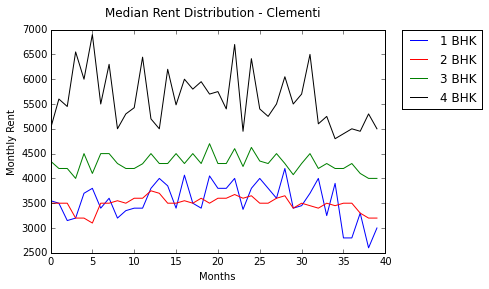

In [39]:
prop_group = prop_list.groupby(["running_months","bedrooms"])["monthly_rent"]
X_grouped = pd.DataFrame(prop_group.median())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped.sort_index(axis=1)
X_grouped.head()

X_1=X_grouped[X_grouped["bedrooms"]==1] ## blue
X_2=X_grouped[X_grouped["bedrooms"]==2] ## red
X_3=X_grouped[X_grouped["bedrooms"]==3] ## green
X_4=X_grouped[X_grouped["bedrooms"]==4] ## black

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab

fig = plt.figure()
fig.suptitle("Median Rent Distribution - Clementi", fontsize=12)
plt.xlabel("Months")
plt.ylabel("Monthly Rent")
pylab.plot(X_1["running_months"],X_1["monthly_rent"],'blue',label="1 BHK")
pylab.plot(X_2["running_months"],X_2["monthly_rent"],'red',label="2 BHK")
pylab.plot(X_3["running_months"],X_3["monthly_rent"],'green',label="3 BHK")
pylab.plot(X_4["running_months"],X_4["monthly_rent"],'black',label="4 BHK")
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/home/vagrant/miniconda3/envs/pyguru/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/home/vagrant/miniconda3/envs/pyguru/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


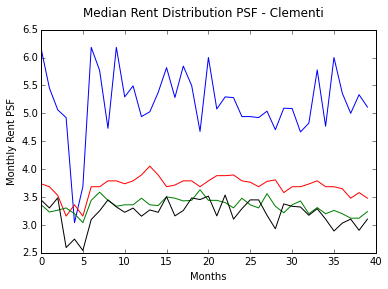

In [53]:
prop_list = prop_list[["area_sqft_min","area_sqft_max","running_months","bedrooms","monthly_rent"]]
prop_list["area"] = ((prop_list["area_sqft_max"] + prop_list["area_sqft_min"])/float(2))
prop_list["psf"] = ((prop_list["monthly_rent"])/(prop_list["area"]))

prop_group = prop_list.groupby(["running_months","bedrooms"])["psf"]
X_grouped = pd.DataFrame(prop_group.median())
X_grouped = X_grouped.reset_index()
X_grouped = X_grouped.sort_index(axis=1)
X_grouped.head()

X_1=X_grouped[X_grouped["bedrooms"]==1] ## blue
X_2=X_grouped[X_grouped["bedrooms"]==2] ## red
X_3=X_grouped[X_grouped["bedrooms"]==3] ## green
X_4=X_grouped[X_grouped["bedrooms"]==4] ## black

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Median Rent Distribution PSF - Clementi", fontsize=12)
plt.xlabel("Months")
plt.ylabel("Monthly Rent PSF")
plt.plot(X_1["running_months"],X_1["psf"],'blue',X_2["running_months"],X_2["psf"],'red',X_3["running_months"],X_3["psf"],'green',X_4["running_months"],X_4["psf"],'black')


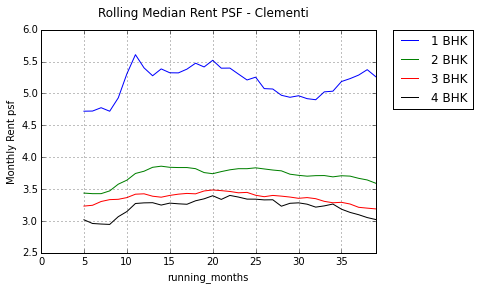

In [54]:
fig = plt.figure()

fig.suptitle("Rolling Median Rent PSF - Clementi", fontsize=12)

plt.xlabel("Months")
plt.ylabel("Monthly Rent psf")

X_1 = X_1.set_index(["running_months"])
X_2 = X_2.set_index(["running_months"])
X_3 = X_3.set_index(["running_months"])
X_4 = X_4.set_index(["running_months"])
pd.rolling_mean(X_1["psf"],6).plot(color='blue',label="1 BHK")
pd.rolling_mean(X_2["psf"],6).plot(color='green',label="2 BHK")
pd.rolling_mean(X_3["psf"],6).plot(color='red',label="3 BHK")
pd.rolling_mean(X_4["psf"],6).plot(color='black',label="4 BHK")
#plt.xlim([0,50])
pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [49]:
X_1

,bedrooms,psf,running_months
0,1,6.167832,0
4,1,5.454545,1
8,1,5.061497,2
13,1,4.923077,3
18,1,3.040000,4
22,1,3.684211,5
27,1,6.181818,6
32,1,5.769231,7
37,1,4.730769,8
42,1,6.181818,9


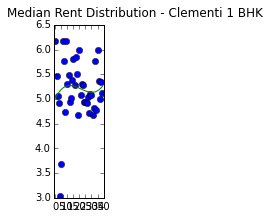

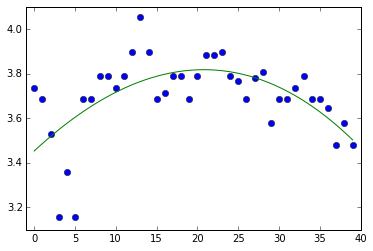

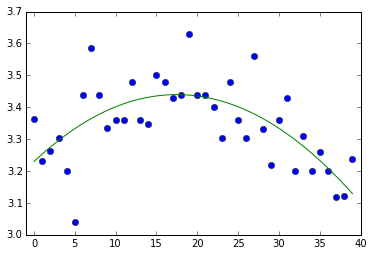

In [281]:
fig = plt.figure(figsize=(3, 3.1))

## One BHK
x = np.array(X_1["running_months"])
y = np.array(X_1["psf"])

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

fig.add_subplot(1,3,1)
#plt.subplot(1,3,1)
fig.suptitle("Median Rent Distribution - Clementi 1 BHK", fontsize=12)
plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

## Two BHK
x = np.array(X_2["running_months"])
y = np.array(X_2["psf"])

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

fig.add_subplot(1,3,2)
#plt.subplot(1,3,2)
fig.suptitle("Median Rent Distribution - Clementi 2 BHK", fontsize=12)
plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

## Three BHK
x = np.array(X_3["running_months"])
y = np.array(X_3["psf"])

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

fig.add_subplot(1,3,3)
#plt.subplot(1,3,3)
fig.suptitle("Median Rent Distribution - Clementi 3 BHK", fontsize=12)
plt.plot(x,y,'o', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()

In [ ]:
## Four BHK
x = np.array(X_4["running_months"])
y = np.array(X_4["psf"])

# calculate polynomial
z = np.polyfit(x, y, 3)
f = np.poly1d(z)

x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.subplot(2,2,4)
fig.suptitle("Median Rent Distribution - Clementi 4 BHK", fontsize=12)
plt.plot(x,y,'red', x_new, y_new)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.show()


